Loading image from: C:\Users\LENOVA\Desktop\Sem-VII\Project\Convolution on 224x224 image\00170_colors.png
Successfully loaded and resized image.
Loaded image. Shape: (224, 224), Dtype: uint8
Quantized int8 kernel (3x3):
 [[  63    0  -63]
 [ 127    0 -127]
 [  63    0  -63]]

Padded 8x8 kernel for Verilog:
 [[  63    0  -63    0    0    0    0    0]
 [ 127    0 -127    0    0    0    0    0]
 [  63    0  -63    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]]

Generating Golden Model using PADDED 8x8 KERNEL...

Starting bit-accurate convolution for 217x217 output...
  ...processing row 20/217
  ...processing row 40/217
  ...processing row 60/217
  ...processing row 80/217
  ...processing row 100/217
  ...processing row 120/217
  ...processing row 140/217
  ...processing row 160/217
  ...processing r

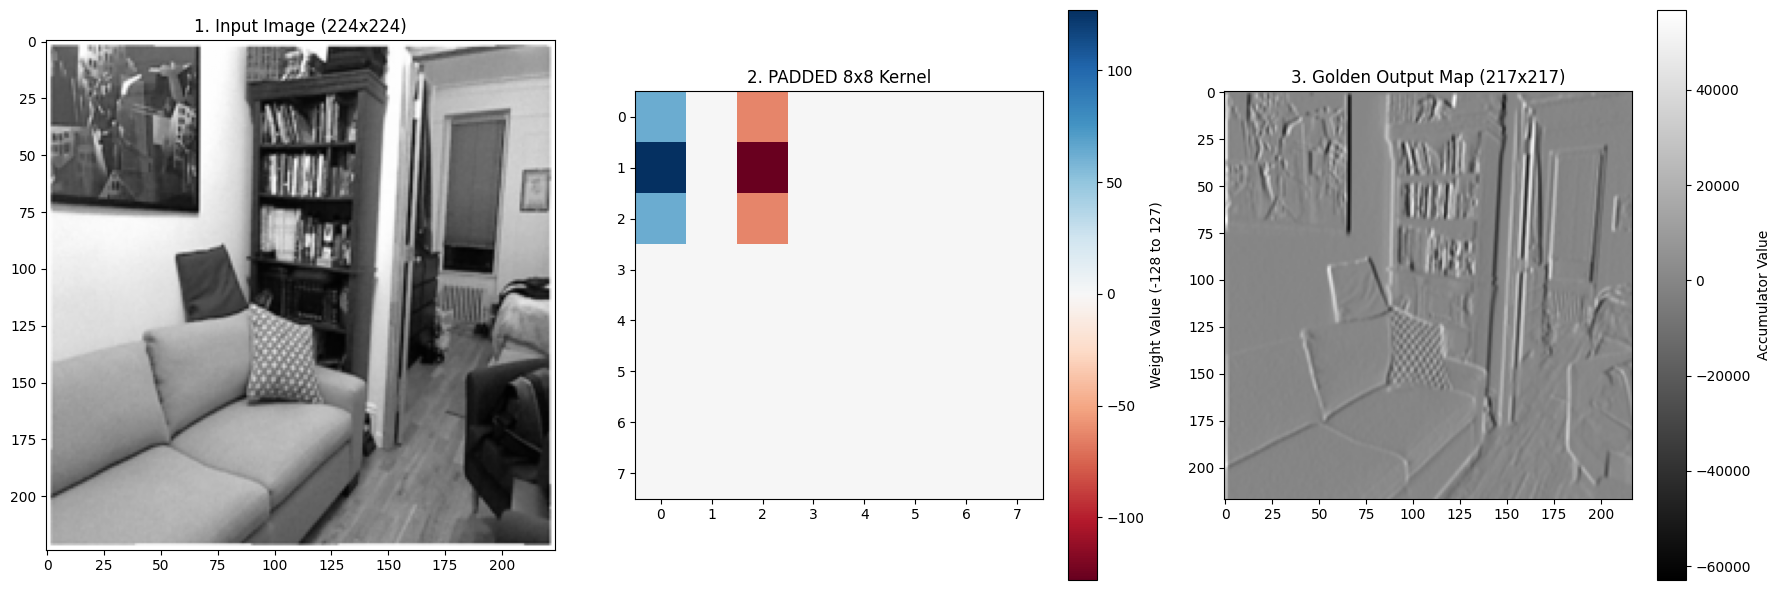


Successfully saved data for Verilog:
  - image_input_224.txt (50176 lines)
  - kernel_input_3x3_padded_8x8.txt (64 lines)
  - python_golden_output_217.txt (47089 lines)


In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time
from PIL import Image

PIXEL_WIDTH = 8
WEIGHT_WIDTH = 8
ACCUM_WIDTH = 32

IMG_HEIGHT = 224
IMG_WIDTH = 224

KERNEL_H_LOGICAL = 3
KERNEL_W_LOGICAL = 3

HARDWARE_K_H = 8
HARDWARE_K_W = 8

WEIGHT_SCALE_FACTOR = 2**(WEIGHT_WIDTH - 1) - 1

def quantize_weight(weight_float):
    scaled = weight_float * WEIGHT_SCALE_FACTOR
    clamped = np.clip(scaled, -128, 127)
    return clamped.astype(np.int8)

IMAGE_PATH = r"C:\Users\LENOVA\Desktop\Sem-VII\Project\Convolution on 224x224 image\00170_colors.png" 

try:
    print(f"Loading image from: {IMAGE_PATH}")
    image_pil = Image.open(IMAGE_PATH).convert('L').resize((IMG_WIDTH, IMG_HEIGHT))
    image = np.array(image_pil, dtype=np.uint8)
    print(f"Successfully loaded and resized image.")
except Exception as e:
    print(f"Error loading image: {e}. Using a dummy image.")
    image = np.array(
        [[int(i/10 + j/10) % 2 * 255 for i in range(IMG_WIDTH)] for j in range(IMG_HEIGHT)], 
        dtype=np.uint8
    )
print(f"Loaded image. Shape: {image.shape}, Dtype: {image.dtype}")

kernel_float = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
], dtype=np.float32)
kernel_float = kernel_float / 2.0
kernel_q = quantize_weight(kernel_float)

print("Quantized int8 kernel (3x3):\n", kernel_q)

kernel_padded_q = np.zeros((HARDWARE_K_H, HARDWARE_K_W), dtype=np.int8)
kernel_padded_q[0:KERNEL_H_LOGICAL, 0:KERNEL_W_LOGICAL] = kernel_q

print(f"\nPadded {HARDWARE_K_H}x{HARDWARE_K_W} kernel for Verilog:\n", kernel_padded_q)

def conv2d_integer(image, kernel):
    img_h, img_w = image.shape
    kern_h, kern_w = kernel.shape
    out_h = img_h - kern_h + 1
    out_w = img_w - kern_w + 1
    output_map = np.zeros((out_h, out_w), dtype=np.int32)

    print(f"\nStarting bit-accurate convolution for {out_h}x{out_w} output...")
    start_time = time.time()
    for y in range(out_h):
        if y % 20 == 0 and y > 0:
            print(f"  ...processing row {y}/{out_h}")
        for x in range(out_w):
            accumulator = 0
            for ky in range(kern_h):
                for kx in range(kern_w):
                    pixel = int(image[y + ky, x + kx])
                    weight = int(kernel[ky, kx])
                    product = pixel * weight
                    accumulator += product
            output_map[y, x] = accumulator
    end_time = time.time()
    print(f"Convolution complete. (Took {end_time - start_time:.2f} seconds)")
    return output_map

print("\nGenerating Golden Model using PADDED 8x8 KERNEL...")
output_golden = conv2d_integer(image, kernel_padded_q)

print(f"Output map shape: {output_golden.shape}, Dtype: {output_golden.dtype}")

print("\nDisplaying visualizations...")
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title(f'1. Input Image ({IMG_HEIGHT}x{IMG_WIDTH})')
plt.imshow(image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title(f'2. PADDED 8x8 Kernel')
plt.imshow(kernel_padded_q, cmap='RdBu', vmin=-128, vmax=127)
plt.colorbar(label='Weight Value (-128 to 127)')

plt.subplot(1, 3, 3)
plt.title(f'3. Golden Output Map ({output_golden.shape[0]}x{output_golden.shape[1]})')
plt.imshow(output_golden, cmap='gray')
plt.colorbar(label='Accumulator Value')

plt.tight_layout()
plt.show()

def save_as_hex(data, filename, bits):
    with open(filename, 'w') as f:
        flat_data = data.flatten()
        for val in flat_data:
            if val < 0:
                val = (1 << bits) + val
            hex_digits = math.ceil(bits / 4)
            hex_val = f'{val:0{hex_digits}X}'
            f.write(hex_val + '\n')

save_as_hex(image,           "image_input_224.txt",       bits=PIXEL_WIDTH)
save_as_hex(kernel_padded_q, "kernel_input_3x3_padded_8x8.txt",      bits=WEIGHT_WIDTH) 
save_as_hex(output_golden,   "python_golden_output_217.txt", bits=ACCUM_WIDTH)

print(f"\nSuccessfully saved data for Verilog:")
print(f"  - image_input_224.txt ({image.size} lines)")
print(f"  - kernel_input_3x3_padded_8x8.txt ({kernel_padded_q.size} lines)")
print(f"  - python_golden_output_217.txt ({output_golden.size} lines)")

--- Starting Verification ---
Loading Python golden file: python_golden_output_217.txt
Loading Verilog output file: verilog_output_217.txt

Loaded 47089 values from Python file.
Loaded 47089 values from Verilog file.

---  TEST PASSED! ---
All 47089 values are bit-accurate.

Attempting to generate visual comparison...
Data reshaped. Displaying images...


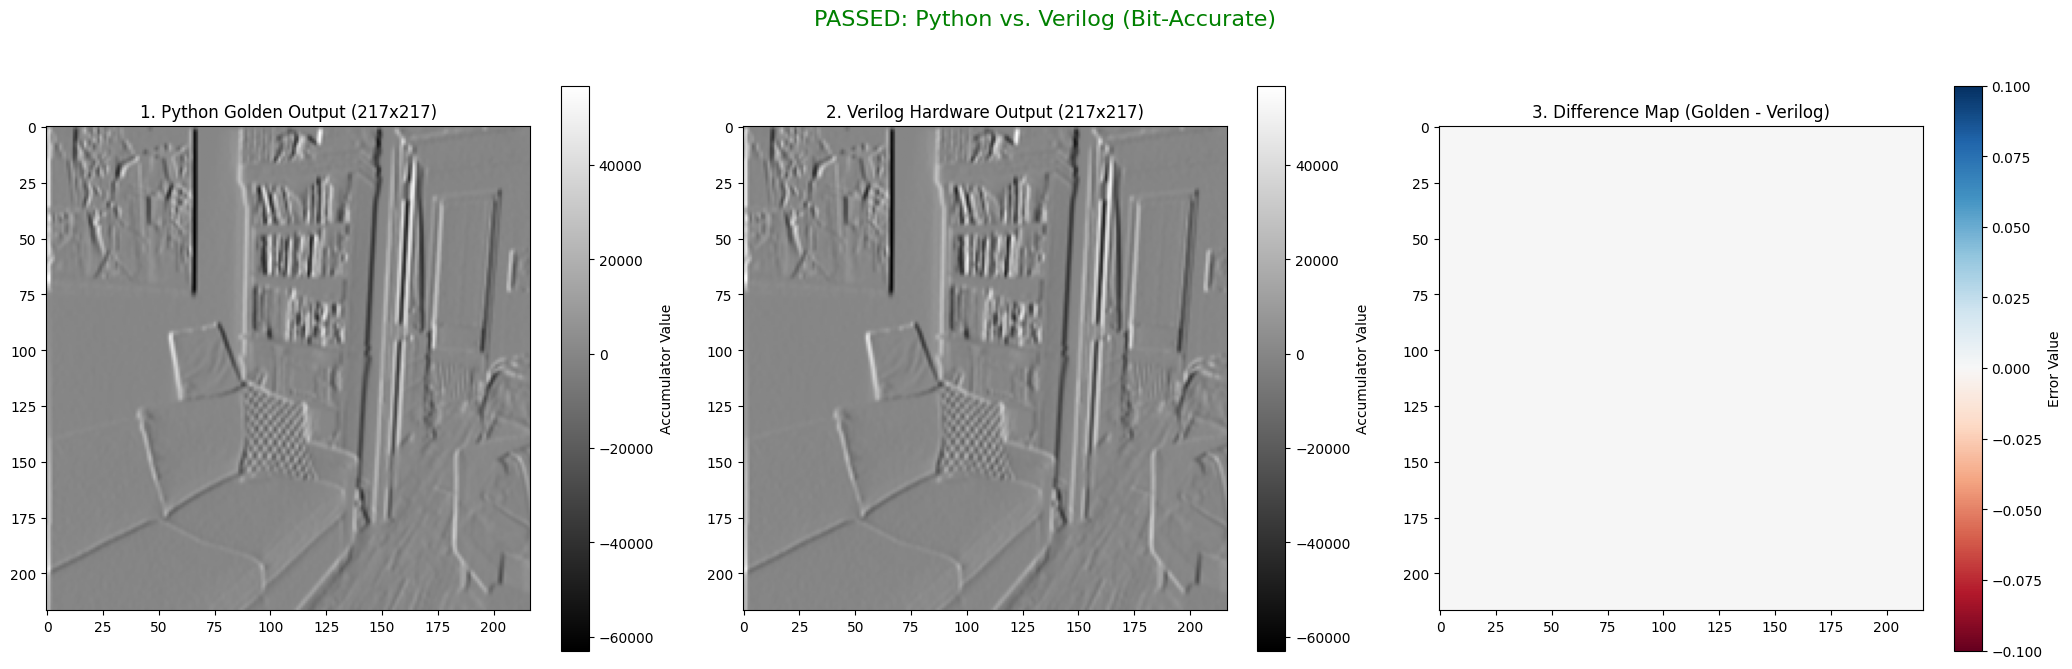

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sys

# --- 1. Define Parameters for "Our Case" ---
PYTHON_GOLDEN_FILE = "python_golden_output_217.txt"
VERILOG_OUTPUT_FILE = "verilog_output_217.txt"

# Both Python and Verilog use 32-bit accumulators in our design
ACCUM_WIDTH = 32 

# Output dimensions: (224 - 8 + 1) = 217
OUT_HEIGHT = 217
OUT_WIDTH = 217
EXPECTED_ELEMENTS = OUT_HEIGHT * OUT_WIDTH

# --- 2. Utility Function to Read Data ---
def read_hex_file(filename, bits):
    """Reads a Verilog-style hex file and converts to signed integers."""
    values = []
    try:
        with open(filename, 'r') as f:
            for line_num, line in enumerate(f, 1):
                line = line.strip()
                if not line:
                    continue
                
                try:
                    # Convert from hex string to integer
                    val = int(line, 16)
                except ValueError:
                    print(f"Warning: Non-hex value '{line}' in {filename} at line {line_num}. Skipping.")
                    continue
                
                # Handle 2's complement
                if val >= (1 << (bits - 1)):
                    val -= (1 << bits)
                values.append(val)
                
    except FileNotFoundError:
        print(f"---  ERROR ---")
        print(f"Could not find file: {filename}")
        return None
    except Exception as e:
        print(f"---  ERROR ---")
        print(f"An error occurred reading {filename}: {e}")
        return None
        
    return np.array(values, dtype=np.int32)

# --- 3. Load Data ---
print("--- Starting Verification ---")
print(f"Loading Python golden file: {PYTHON_GOLDEN_FILE}")
golden_data = read_hex_file(PYTHON_GOLDEN_FILE, bits=ACCUM_WIDTH)

print(f"Loading Verilog output file: {VERILOG_OUTPUT_FILE}")
verilog_data = read_hex_file(VERILOG_OUTPUT_FILE, bits=ACCUM_WIDTH)

# Abort if files weren't loaded
if golden_data is None or verilog_data is None:
    print("\nComparison aborted due to file read errors.")
    sys.exit(1) # Exit the script with an error code

print(f"\nLoaded {len(golden_data)} values from Python file.")
print(f"Loaded {len(verilog_data)} values from Verilog file.")

# --- 4. Text-Based Comparison ---
test_passed = False
if len(golden_data) != len(verilog_data):
    print("\n---  TEST FAILED: Length Mismatch ---")
    print(f"  Python file has {len(golden_data)} elements.")
    print(f"  Verilog file has {len(verilog_data)} elements.")
    print(f"  Expected {EXPECTED_ELEMENTS} elements for a {OUT_HEIGHT}x{OUT_WIDTH} output.")

elif np.array_equal(golden_data, verilog_data):
    print("\n---  TEST PASSED! ---")
    print(f"All {len(golden_data)} values are bit-accurate.")
    test_passed = True

else:
    print("\n---  TEST FAILED: Data Mismatch ---")
    abs_error = np.abs(golden_data - verilog_data)
    avg_error = np.mean(abs_error)
    print(f"  Average Absolute Error: {avg_error:.2f}")

    # Find the first mismatch
    mismatch_indices = np.where(golden_data != verilog_data)[0]
    first_mismatch_idx = mismatch_indices[0]
    
    print(f"\n  First mismatch at index {first_mismatch_idx}:")
    print(f"    Golden [Python]:  {golden_data[first_mismatch_idx]}")
    print(f"    Output [Verilog]: {verilog_data[first_mismatch_idx]}")


# --- 5. Visual Comparison ---
print("\nAttempting to generate visual comparison...")
try:
    # Reshape flattened data into 2D images
    golden_image = golden_data.reshape((OUT_HEIGHT, OUT_WIDTH))
    verilog_image = verilog_data.reshape((OUT_HEIGHT, OUT_WIDTH))
    
    # Create a difference map (most important visual!)
    diff_image = golden_image - verilog_image
    
    print("Data reshaped. Displaying images...")

    # Plot
    plt.figure(figsize=(21, 7)) # Wider figure for 3 plots
    
    # Plot 1: Python Golden Output
    plt.subplot(1, 3, 1)
    plt.title(f"1. Python Golden Output ({OUT_HEIGHT}x{OUT_WIDTH})")
    plt.imshow(golden_image, cmap='gray')
    plt.colorbar(label="Accumulator Value")

    # Plot 2: Verilog Hardware Output
    plt.subplot(1, 3, 2)
    plt.title(f"2. Verilog Hardware Output ({OUT_HEIGHT}x{OUT_WIDTH})")
    plt.imshow(verilog_image, cmap='gray')
    plt.colorbar(label="Accumulator Value")

    # Plot 3: Difference Map
    plt.subplot(1, 3, 3)
    plt.title(f"3. Difference Map (Golden - Verilog)")
    plt.imshow(diff_image, cmap='RdBu') # Red/Blue is good for diff
    plt.colorbar(label="Error Value")

    if test_passed:
        plt.suptitle("PASSED: Python vs. Verilog (Bit-Accurate)", fontsize=16, color='green')
    else:
        plt.suptitle("FAILED: Python vs. Verilog (See Diffs)", fontsize=16, color='red')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

except ValueError as e:
    print("\n--- Visualizer Failed ---")
    print(f"Could not reshape array(s) for plotting.")
    print(f"Error: {e}")
    print("This usually happens if the file lengths were mismatched.")

Loaded image: (224, 224)

--- Generating 7x7 Kernel ---
Logical Kernel (Quantized):
 [[2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]]

Hardware Kernel Input (8x8 Padded):
 [[2 2 2 2 2 2 2 0]
 [2 2 2 2 2 2 2 0]
 [2 2 2 2 2 2 2 0]
 [2 2 2 2 2 2 2 0]
 [2 2 2 2 2 2 2 0]
 [2 2 2 2 2 2 2 0]
 [2 2 2 2 2 2 2 0]
 [0 0 0 0 0 0 0 0]]
Computing Golden Output: 218x218...

--- Files Generated ---
1. Image:  image_input_224.txt
2. Kernel: kernel_input_7x7_padded_8x8.txt (Use this in $readmemh)
3. Golden: python_golden_output_218.txt (Use this for comparison)


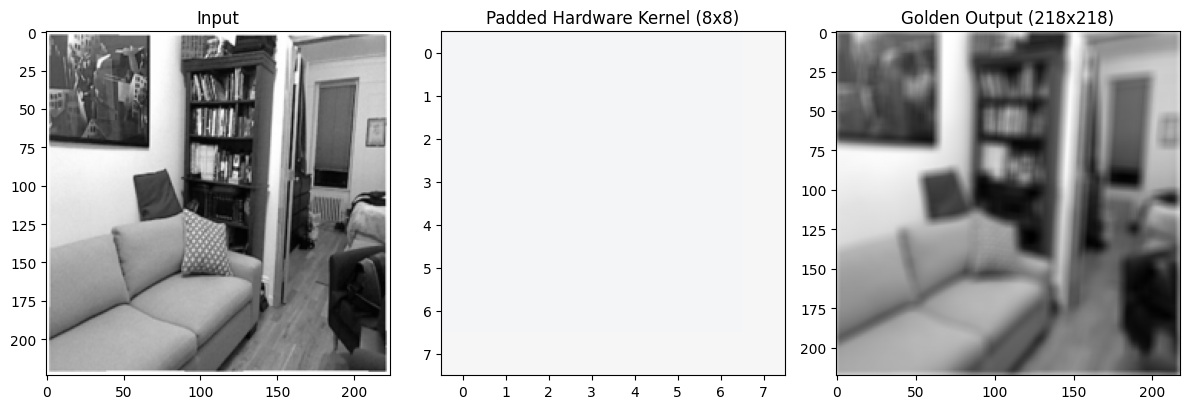

In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time
from PIL import Image

# ==========================================
# USER SELECTION: CHOOSE YOUR KERNEL SIZE
# Options: 1, 3, 5, 7
# ==========================================
LOGICAL_K_SIZE = 7
# ==========================================

# --- Parameters ---
PIXEL_WIDTH = 8
WEIGHT_WIDTH = 8
ACCUM_WIDTH = 32

IMG_HEIGHT = 224
IMG_WIDTH = 224

# Hardware is fixed at 8x8
HARDWARE_K_H = 8
HARDWARE_K_W = 8

WEIGHT_SCALE_FACTOR = 2**(WEIGHT_WIDTH - 1) - 1

def quantize_weight(weight_float):
    scaled = weight_float * WEIGHT_SCALE_FACTOR
    clamped = np.clip(scaled, -128, 127)
    return clamped.astype(np.int8)

# --- 1. Load Image ---
# Replace with your path or use the dummy generator below
IMAGE_PATH = r"C:\Users\LENOVA\Desktop\Sem-VII\Project\Convolution on 224x224 image\00170_colors.png" 

try:
    image_pil = Image.open(IMAGE_PATH).convert('L').resize((IMG_WIDTH, IMG_HEIGHT))
    image = np.array(image_pil, dtype=np.uint8)
    print(f"Loaded image: {image.shape}")
except:
    print("Image file not found, generating dummy gradient image.")
    image = np.array(
        [[int((i+j)/2) % 255 for i in range(IMG_WIDTH)] for j in range(IMG_HEIGHT)], 
        dtype=np.uint8
    )

# --- 2. Generate Kernel based on Selection ---
print(f"\n--- Generating {LOGICAL_K_SIZE}x{LOGICAL_K_SIZE} Kernel ---")

if LOGICAL_K_SIZE == 1:
    # Simple scaler
    kernel_float = np.array([[1.5]]) 

elif LOGICAL_K_SIZE == 3:
    # Edge Detection
    kernel_float = np.array([
        [1, 0, -1],
        [2, 0, -2],
        [1, 0, -1]
    ])

elif LOGICAL_K_SIZE == 5:
    # 5x5 Identity with negative corners (Arbitrary filter)
    kernel_float = np.zeros((5,5))
    kernel_float[2,2] = 2.0   # Center
    kernel_float[0,0] = -0.5  # Corner
    kernel_float[0,4] = -0.5
    kernel_float[4,0] = -0.5
    kernel_float[4,4] = -0.5

elif LOGICAL_K_SIZE == 7:
    # 7x7 Box Blur (approx)
    kernel_float = np.ones((7,7)) / 49.0

else:
    raise ValueError("Unsupported Kernel Size")

# Normalize to ensure values are within decent range for quantization
kernel_q = quantize_weight(kernel_float)
print("Logical Kernel (Quantized):\n", kernel_q)

# --- 3. Prepare Hardware Padding (The 8x8 Matrix) ---
kernel_padded_hw = np.zeros((HARDWARE_K_H, HARDWARE_K_W), dtype=np.int8)
# Place the logical kernel in the TOP-LEFT corner
kernel_padded_hw[0:LOGICAL_K_SIZE, 0:LOGICAL_K_SIZE] = kernel_q

print(f"\nHardware Kernel Input (8x8 Padded):\n", kernel_padded_hw)

# --- 4. Perform Convolution (Golden Model) ---
def conv2d_sw(image, logical_kern):
    img_h, img_w = image.shape
    k_h, k_w = logical_kern.shape # Uses logical size (e.g. 5x5)
    
    out_h = img_h - k_h + 1
    out_w = img_w - k_w + 1
    
    output = np.zeros((out_h, out_w), dtype=np.int32)
    
    print(f"Computing Golden Output: {out_h}x{out_w}...")
    
    # Naive convolution loop (Matches hardware logic)
    for y in range(out_h):
        for x in range(out_w):
            acc = 0
            for ky in range(k_h):
                for kx in range(k_w):
                    val = int(image[y+ky, x+kx]) * int(logical_kern[ky, kx])
                    acc += val
            output[y, x] = acc
            
    return output

output_golden = conv2d_sw(image, kernel_q)

# --- 5. Save Hex Files for Verilog ---
def save_as_hex(data, filename, bits):
    with open(filename, 'w') as f:
        flat = data.flatten()
        for val in flat:
            if val < 0: val = (1 << bits) + val
            # Fixed the float/int casting issue here
            hex_digits = int(math.ceil(bits / 4)) 
            f.write(f'{val:0{hex_digits}X}\n')

# Filenames indicate the size for clarity
file_img = "image_input_224.txt"
file_ker = f"kernel_input_{LOGICAL_K_SIZE}x{LOGICAL_K_SIZE}_padded_8x8.txt"
file_out = f"python_golden_output_{output_golden.shape[0]}.txt"

save_as_hex(image, file_img, 8)
save_as_hex(kernel_padded_hw, file_ker, 8) # Note: Saving the PADDED kernel
save_as_hex(output_golden, file_out, 32)

print(f"\n--- Files Generated ---")
print(f"1. Image:  {file_img}")
print(f"2. Kernel: {file_ker} (Use this in $readmemh)")
print(f"3. Golden: {file_out} (Use this for comparison)")

# --- 6. Visualize ---
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1); plt.title("Input"); plt.imshow(image, cmap='gray')
plt.subplot(1,3,2); plt.title(f"Padded Hardware Kernel (8x8)"); plt.imshow(kernel_padded_hw, cmap='RdBu', vmin=-128, vmax=127)
plt.subplot(1,3,3); plt.title(f"Golden Output ({output_golden.shape[0]}x{output_golden.shape[1]})"); plt.imshow(output_golden, cmap='gray')
plt.tight_layout()
plt.show()


--- Verifying Convolution (Mode: 7x7) ---
Expected Output Shape: 218x218
Reading: python_golden_output_218.txt... [OK] (47524 values)
Reading: verilog_output_multimode.txt... [OK] (47524 values)

[SUCCESS] CONGRATULATIONS! Bit-Perfect Match.
   All 47524 pixels match exactly.

Launching Visualization...


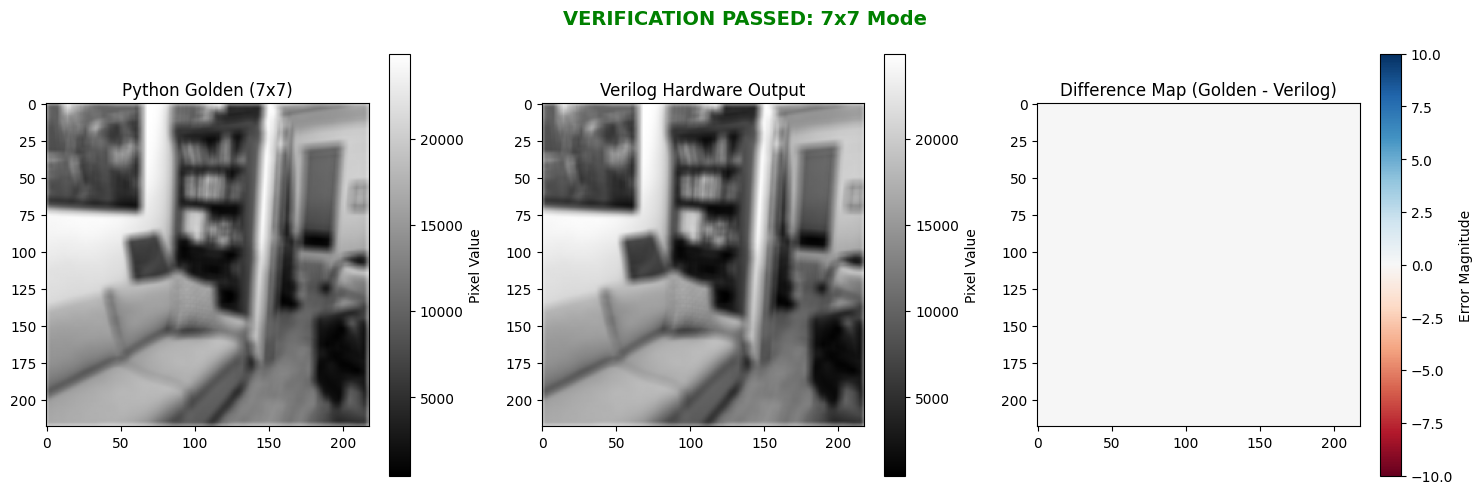

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# =================================================================
#  CONFIGURATION: MATCH THIS TO YOUR VERILOG TEST
# =================================================================
KERNEL_SIZE_USED = 7   # Options: 1, 3, 5, 7

# Expected dimensions based on the kernel size
IMG_WIDTH = 224
EXPECTED_DIM = IMG_WIDTH - KERNEL_SIZE_USED + 1

# File Names (Must match what the Generator and Testbench produced)
FILE_PYTHON_GOLDEN = f"python_golden_output_{EXPECTED_DIM}.txt"
FILE_VERILOG_OUT   = "verilog_output_multimode.txt"
# =================================================================

def read_hex_file(filename):
    """Reads a hex file (signed 32-bit) into a numpy array."""
    data = []
    print(f"Reading: {filename}...", end="")
    
    if not os.path.exists(filename):
        print(f" [FAILED]\n   Error: File not found.")
        return None

    try:
        with open(filename, 'r') as f:
            for line in f:
                line = line.strip()
                if not line: continue
                
                # Convert Hex to Int (32-bit Signed)
                val = int(line, 16)
                if val >= (1 << 31):
                    val -= (1 << 32)
                data.append(val)
        
        print(f" [OK] ({len(data)} values)")
        return np.array(data, dtype=np.int32)
        
    except Exception as e:
        print(f" [ERROR] {e}")
        return None

# --- Main Execution ---
print(f"\n--- Verifying Convolution (Mode: {KERNEL_SIZE_USED}x{KERNEL_SIZE_USED}) ---")
print(f"Expected Output Shape: {EXPECTED_DIM}x{EXPECTED_DIM}")

# 1. Load Data
golden_data = read_hex_file(FILE_PYTHON_GOLDEN)
verilog_data = read_hex_file(FILE_VERILOG_OUT)

if golden_data is None or verilog_data is None:
    print("\nCannot proceed. Please check your file paths.")
    sys.exit(1)

# 2. Basic Validations
if len(golden_data) != len(verilog_data):
    print(f"\n[FAIL] Length Mismatch!")
    print(f"   Python Expected: {len(golden_data)}")
    print(f"   Verilog Output:  {len(verilog_data)}")
    print("   Hint: Did you update the 'total_pixels_to_dump' logic in the Verilog TB?")
    sys.exit(1)

# 3. Bit-Accurate Comparison
mismatches = np.sum(golden_data != verilog_data)

if mismatches == 0:
    print(f"\n[SUCCESS] CONGRATULATIONS! Bit-Perfect Match.")
    print(f"   All {len(golden_data)} pixels match exactly.")
else:
    print(f"\n[FAIL] Data Mismatch Found.")
    print(f"   Total Mismatches: {mismatches} / {len(golden_data)}")
    
    # Calculate Error Stats
    diff = np.abs(golden_data - verilog_data)
    print(f"   Max Absolute Error: {np.max(diff)}")
    print(f"   Mean Absolute Error: {np.mean(diff):.4f}")
    
    # Find first error index
    idx = np.where(golden_data != verilog_data)[0][0]
    print(f"   First Mismatch at Index {idx}:")
    print(f"     Expected: {golden_data[idx]}")
    print(f"     Got:      {verilog_data[idx]}")

# 4. Visualization
print("\nLaunching Visualization...")
try:
    # Reshape to 2D images
    img_golden = golden_data.reshape((EXPECTED_DIM, EXPECTED_DIM))
    img_verilog = verilog_data.reshape((EXPECTED_DIM, EXPECTED_DIM))
    img_diff = img_golden - img_verilog

    plt.figure(figsize=(15, 5))

    # Plot 1: Python Golden
    plt.subplot(1, 3, 1)
    plt.title(f"Python Golden ({KERNEL_SIZE_USED}x{KERNEL_SIZE_USED})")
    plt.imshow(img_golden, cmap='gray')
    plt.colorbar(label="Pixel Value")

    # Plot 2: Verilog Output
    plt.subplot(1, 3, 2)
    plt.title("Verilog Hardware Output")
    plt.imshow(img_verilog, cmap='gray')
    plt.colorbar(label="Pixel Value")

    # Plot 3: Difference Map (Crucial for debugging)
    plt.subplot(1, 3, 3)
    plt.title("Difference Map (Golden - Verilog)")
    # Use RdBu colormap: White=0 error, Red=Positive error, Blue=Negative error
    plt.imshow(img_diff, cmap='RdBu', vmin=-10, vmax=10) 
    plt.colorbar(label="Error Magnitude")

    if mismatches == 0:
        plt.suptitle(f"VERIFICATION PASSED: {KERNEL_SIZE_USED}x{KERNEL_SIZE_USED} Mode", color='green', fontsize=14, weight='bold')
    else:
        plt.suptitle(f"VERIFICATION FAILED: {mismatches} Errors", color='red', fontsize=14, weight='bold')

    plt.tight_layout()
    plt.show()

except ValueError as e:
    print(f"\n[Visualizer Error] Could not reshape data. {e}")

In [19]:
import numpy as np
import math
import os
from PIL import Image # Requires: pip install pillow

# ==========================================
# USER SETTINGS
# ==========================================
IMAGE_PATH = r"C:\Users\LENOVA\Desktop\Sem-VII\Project\Convolution on 224x224 image\00170_colors.png" # <--- PUT YOUR IMAGE FILE NAME HERE
LOGICAL_K_SIZE = 3               # Options: 1, 3, 5, 7
IMG_W = 224
IMG_H = 224
# ==========================================

# --- Hardware Constants (Do Not Change) ---
HW_BUFFER_SIZE = 8 
OUT_DIM = IMG_W - HW_BUFFER_SIZE + 1

def quantize_weight(weight_float):
    scaled = weight_float * 127.0
    return np.clip(scaled, -128, 127).astype(np.int8)

def save_hex(data, filename, bits):
    print(f"Saving {filename}...", end="")
    with open(filename, 'w') as f:
        for val in data.flatten():
            if val < 0: val = (1 << bits) + val
            digits = int(math.ceil(bits/4))
            f.write(f'{val:0{digits}X}\n')
    print(" Done.")

# --- 1. Load User Image ---
print(f"--- Processing User Image for {LOGICAL_K_SIZE}x{LOGICAL_K_SIZE} Mode ---")

if not os.path.exists(IMAGE_PATH):
    print(f"[ERROR] Could not find image: {IMAGE_PATH}")
    print("Please ensure the file is in this folder or update IMAGE_PATH.")
    exit()

try:
    # Load, convert to Grayscale (L), and Resize to 224x224
    orig_img = Image.open(IMAGE_PATH).convert('L')
    orig_img = orig_img.resize((IMG_W, IMG_H))
    image = np.array(orig_img, dtype=np.uint8)
    print(f"[OK] Loaded and resized image to {image.shape}")
except Exception as e:
    print(f"[ERROR] Failed to load image: {e}")
    exit()

# --- 2. Generate Kernel ---
if LOGICAL_K_SIZE == 1:
    k_float = np.array([[1.5]])
elif LOGICAL_K_SIZE == 3:
    k_float = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]]) # Sobel Edge
elif LOGICAL_K_SIZE == 5:
    k_float = np.ones((5,5)) * 0.04
    k_float[2,2] = 2.0; k_float[0,0] = -1.0 # Sharpen
elif LOGICAL_K_SIZE == 7:
    k_float = np.eye(7) * 0.2 # Identity/Motion
else:
    k_float = np.ones((LOGICAL_K_SIZE, LOGICAL_K_SIZE))

k_q = quantize_weight(k_float)

# --- 3. Pad Kernel for 8x8 Hardware ---
k_padded = np.zeros((HW_BUFFER_SIZE, HW_BUFFER_SIZE), dtype=np.int8)
k_padded[0:LOGICAL_K_SIZE, 0:LOGICAL_K_SIZE] = k_q

# --- 4. Compute Golden Output (Hardware Accurate) ---
output_golden = np.zeros((OUT_DIM, OUT_DIM), dtype=np.int32)

print(f"Computing Golden Output ({OUT_DIM}x{OUT_DIM})...")
# Simulating the 8x8 Line Buffer Window
for y in range(OUT_DIM):
    for x in range(OUT_DIM):
        acc = 0
        for ky in range(HW_BUFFER_SIZE):
            for kx in range(HW_BUFFER_SIZE):
                w_val = int(k_padded[ky, kx])
                p_val = int(image[y+ky, x+kx])
                acc += w_val * p_val
        output_golden[y, x] = acc

# --- 5. Save Files ---
save_hex(image, "image_input_224.txt", 8)
save_hex(k_padded, f"kernel_input_{LOGICAL_K_SIZE}x{LOGICAL_K_SIZE}_padded_8x8.txt", 8)
save_hex(output_golden, "python_golden_streaming.txt", 32)

print("\n[READY] Input files created. Run 'tb_streaming' in Verilog now.")

--- Processing User Image for 3x3 Mode ---
[OK] Loaded and resized image to (224, 224)
Computing Golden Output (217x217)...
Saving image_input_224.txt... Done.
Saving kernel_input_3x3_padded_8x8.txt... Done.
Saving python_golden_streaming.txt... Done.

[READY] Input files created. Run 'tb_streaming' in Verilog now.


--- Verifying Streaming Output (217x217) ---

[SUCCESS] Bit-Perfect Match!
   All 47089 pixels match exactly.

Launching Visualizer...


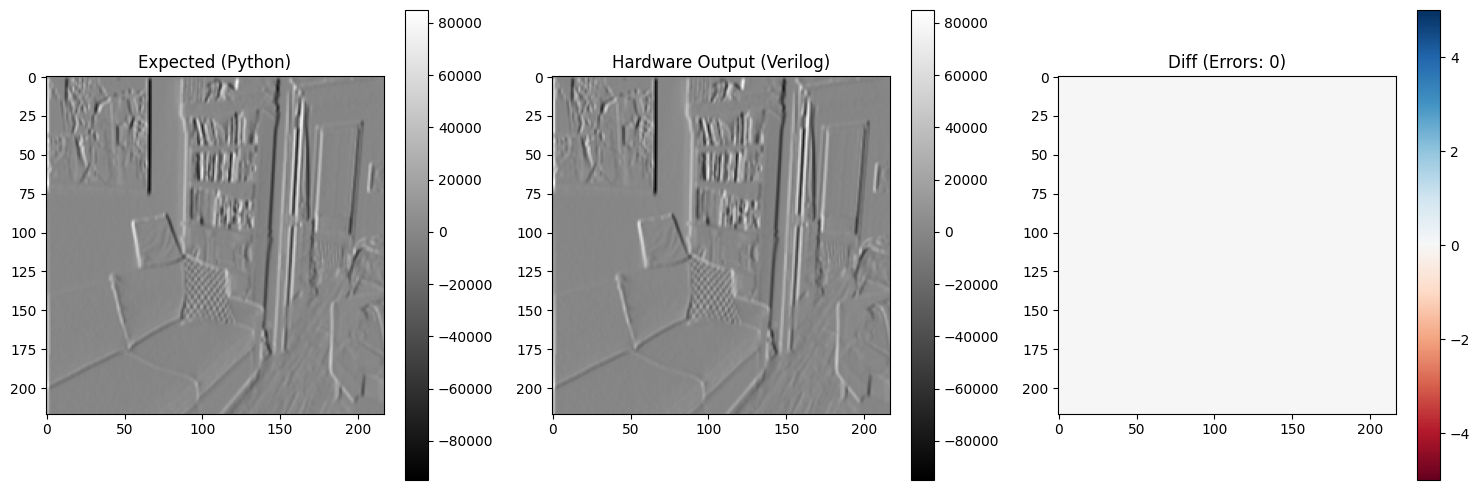

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# ==========================================
# SETTINGS
# Must match the Generator settings!
# ==========================================
IMG_W = 224
HW_BUFFER_SIZE = 8 
OUT_DIM = IMG_W - HW_BUFFER_SIZE + 1

FILE_GOLDEN  = "python_golden_streaming.txt"
FILE_VERILOG = "verilog_output_streaming.txt"
# ==========================================

def read_hex_file(filename):
    """Reads signed hex values from file."""
    if not os.path.exists(filename):
        print(f"[ERROR] File not found: {filename}")
        return None
        
    with open(filename, 'r') as f:
        # Convert hex strings to integers
        raw_vals = [int(line.strip(), 16) for line in f if line.strip()]
        
    # Convert to signed 32-bit integers
    # If val >= 2^31, subtract 2^32 to get negative value
    signed_vals = [x if x < (1<<31) else x - (1<<32) for x in raw_vals]
    return np.array(signed_vals, dtype=np.int32)

print(f"--- Verifying Streaming Output ({OUT_DIM}x{OUT_DIM}) ---")

# 1. Load Data
golden = read_hex_file(FILE_GOLDEN)
verilog = read_hex_file(FILE_VERILOG)

if golden is None or verilog is None:
    print("Aborting verification.")
    sys.exit(1)

# 2. Length Check
if len(golden) != len(verilog):
    print(f"\n[FAIL] Output Length Mismatch!")
    print(f"   Expected (Python): {len(golden)}")
    print(f"   Got (Verilog):     {len(verilog)}")
    print("   Tip: Check 'TOTAL_OUTPUTS' in your Verilog Testbench.")
    sys.exit(1)

# 3. Data Comparison
diff = np.abs(golden - verilog)
mismatches = np.count_nonzero(diff)

if mismatches == 0:
    print("\n[SUCCESS] Bit-Perfect Match!")
    print(f"   All {len(golden)} pixels match exactly.")
else:
    print(f"\n[FAIL] Found {mismatches} mismatches.")
    print(f"   Max Error: {np.max(diff)}")
    print(f"   Avg Error: {np.mean(diff):.4f}")

# 4. Visualization
print("\nLaunching Visualizer...")
try:
    img_g = golden.reshape(OUT_DIM, OUT_DIM)
    img_v = verilog.reshape(OUT_DIM, OUT_DIM)
    img_d = img_g - img_v

    plt.figure(figsize=(15, 5))
    
    plt.subplot(1,3,1)
    plt.title("Expected (Python)")
    plt.imshow(img_g, cmap='gray')
    plt.colorbar()

    plt.subplot(1,3,2)
    plt.title("Hardware Output (Verilog)")
    plt.imshow(img_v, cmap='gray')
    plt.colorbar()

    plt.subplot(1,3,3)
    plt.title(f"Diff (Errors: {mismatches})")
    plt.imshow(img_d, cmap='RdBu', vmin=-5, vmax=5) # Red/Blue contrast
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"[Visualizer Error] Could not reshape data: {e}")